# Word2Vec then RNN

## Imports and setting up TensorBoard

In [1]:
from data_preparation import *
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, TimeDistributed, Dropout, Embedding
from keras.optimizers import Adam
from keras_train_helper import tfauc
from tensorflow.python.client import device_lib
from keras_train_helper import rotateTensorboardLogs
from keras.callbacks import TensorBoard
from keras_train_helper import PrintAucCallback

tensorBoardCallback = TensorBoard(log_dir="../tb-logs")
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 637760516435260262
]


## Loading data and setting up preprocessing tools

In [2]:
train, test, allData, contestTest = loadData()

Loading datasets...
train: (127656, 8), test: (31915, 8), allData: (159571, 8), contestTest: (153164, 2)


In [3]:
from sklearn.pipeline import Pipeline

maxSeqLength = 250

splitter = SentenceSplitter("comment_text")
allWords = pd.concat([splitter.transform(allData), splitter.transform(contestTest)])
w2i = Word2Int(allWords)
zeroPadder = ZeroPadder(maxSeqLength)

preparationPipeline = Pipeline(steps=[
    ("split", splitter),
    ("w2i", w2i),
    ("zeroPadding", zeroPadder) ])

Splitting sentences...
Splitting sentences...
Loading w2i and i2w dictionaries...


In [5]:
import data_preparation
import importlib
importlib.reload(data_preparation)
from data_preparation import *

In [6]:
%%time
w2v = Word2Vec("../../state/external-models/glove.6B/saved-50.bin", 50, w2i.i2w, seed=4324)

Loading word2vec dictionary...
CPU times: user 2.3 s, sys: 64 ms, total: 2.36 s
Wall time: 2.36 s


In [7]:
embeddingMatrix, i2v = w2v.embeddingMatrix()

## Define the model

### Define the model

In [8]:
lstmUnits = 100
numClasses = 2
batchSize = 1024

def defineModel():
    model = Sequential()

    model.add(Embedding(
        embeddingMatrix.shape[0],
        embeddingMatrix.shape[1],
        weights=[embeddingMatrix],
        input_length=maxSeqLength,
        trainable=False))

    model.add(Bidirectional(LSTM(lstmUnits), name="LSTM"))

    model.add(Dropout(.2, name="dropout"))

    model.add(Dense(
        2, 
        activation="softmax", 
        name="softmax_output"))
    
    model.compile(
        loss="categorical_crossentropy", 
        optimizer="nadam", 
        metrics=[tfauc])

    print(model.summary())
    return model

## Prepare data and train the model

In [20]:
def fitModel(model, trainDataset, testDataset, printAucCallback, label, epochs, fast=False):
    print("Training model for target variable: {}".format(label))
    
    tf.set_random_seed(43245)
    np.random.seed(453252)
    
    labelizer = Labelizer(label)
    oversampler = Oversampler(label)
    
    trainOversampled = oversampler.transform(trainDataset)

    trainSentences = preparationPipeline.transform(trainOversampled)
    trainLabels = labelizer.transform(trainOversampled)
    testSentences = preparationPipeline.transform(testDataset)
    testLabels = labelizer.transform(testDataset)

    printAucCallback.setDatasets([trainSentences, trainLabels], [testSentences, testLabels])

    model.fit(
        trainSentences, 
        trainLabels, 
        nb_epoch=epochs, 
        batch_size=batchSize,
        callbacks=[] if fast else [tensorBoardCallback, printAucCallback])
    
    return model, testSentences, testLabels

In [21]:
import keras_train_helper
import importlib
importlib.reload(keras_train_helper)
from keras_train_helper import PrintAucCallback

In [ ]:
%%time
model = defineModel()
printAucCallback = PrintAucCallback(4 * batchSize, printFrequency=0.05)

model, testSentences, testLabels = fitModel(model, train, test, printAucCallback, "toxic", 20)

## Compare train and test data

In [30]:
def getEpochIndices(listOfAucs):
    return [index 
            for index, (iterationType, number, value) 
            in zip(range(len(listOfAucs)), listOfAucs)
            if iterationType == "epoch"]

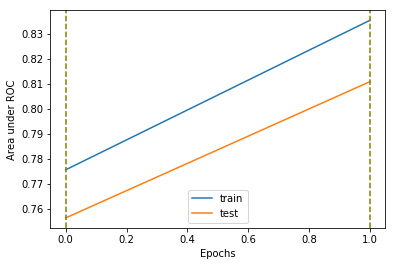

In [31]:
import matplotlib.pyplot as plt
plt.plot([value for _, key, value in printAucCallback.listOfAucsTrain])
plt.plot([value for _, key, value in printAucCallback.listOfAucsTest])

for index in getEpochIndices(printAucCallback.listOfAucsTrain):
    plt.axvline(index, ls="--", color="olive")

plt.legend(["train", "test"])
plt.ylabel("Area under ROC")
plt.xlabel("Epochs")
plt.show()

           P Neutral  P Toxic
T Neutral       1479      319
T Toxic           75      127


           P Neutral  P Toxic
T Neutral     0.7395   0.1595
T Toxic       0.0375   0.0635


0.392


0.4546


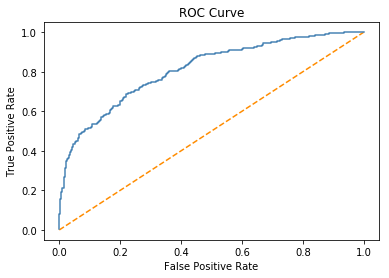

In [29]:
from evaluate_predictions import evaluatePredictions

predictions = model.predict(testSentences, batch_size=4*batchSize)
binaryPredictions = np.where(predictions[:, 1] > 0.5, 1, 0)
labels = testLabels[:, 1]

evaluatePredictions(pd.Series(labels), binaryPredictions, predictions)

## Run on all data and export submission

In [ ]:
%%time
contestModels = [
    fitModel(defineModel(), allData, test, label, epochs, fast=True)
    for (label, epochs)
    in [("toxic", 2), ("severe_toxic", 2), ("obscene", 1), ("threat", 1), ("insult", 1), ("identity_hate", 1)]]

In [ ]:
%%time
categories = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
contestPredictionProbabilities = {category: model.predict(preparationPipeline.transform(contestTest)) for (category, model) in zip(categories, contestModels)}

In [33]:
suffledResult = pd.DataFrame(dict(
    [("id", contestTest.id)] 
    + [(name, preds[:, 1]) for (name, preds) in contestPredictionProbabilities.items()]))

result = suffledResult[["id"] + categories]

In [34]:
result.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.107428,0.086610,0.179781,0.043975,0.104099,0.086608
1,0000247867823ef7,0.147077,0.124943,0.256728,0.045869,0.097912,0.125053
2,00013b17ad220c46,0.144134,0.122432,0.231361,0.073960,0.156137,0.122611
3,00017563c3f7919a,0.094946,0.076373,0.186833,0.022637,0.050725,0.076566
4,00017695ad8997eb,0.105768,0.083794,0.182512,0.037039,0.066183,0.083650


In [ ]:
result.shape

In [45]:
result.to_csv("./submissions/w2v-then-rnn.csv", index=False)